### Using a Pre-trained PyTorch Model for Inference

In this demo, we will use a pre-trained model to perform inference on a single image. 

There are 3 components to this demo:
1. Input
2. Model
3. Output

We will cover these components in detail below.

Let us first import the required packages.


In [109]:
import torch 
import torchvision
import torchvision.transforms as transforms
from einops import rearrange
from PIL import Image

### Model: Loading a pre-trained ResNet18 model

We use a pre-trained ResNet18 model for inference. The model is available from `torchvision`.

When we use a model for inference, we need to specify the `eval` mode. This is because the model is designed for training, and we need to disable all the dropout layers.

In [110]:
# Download and load the pretrained ResNet-18.
resnet = torchvision.models.resnet18(pretrained=True)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Input: Loading an input image

We can use matplotlib `image` to load an image into a numpy array. 

However, PyTorch `transforms` expects a PIL image. While we can convert numpy array to PIL, we can load an image directly into a PIL image.

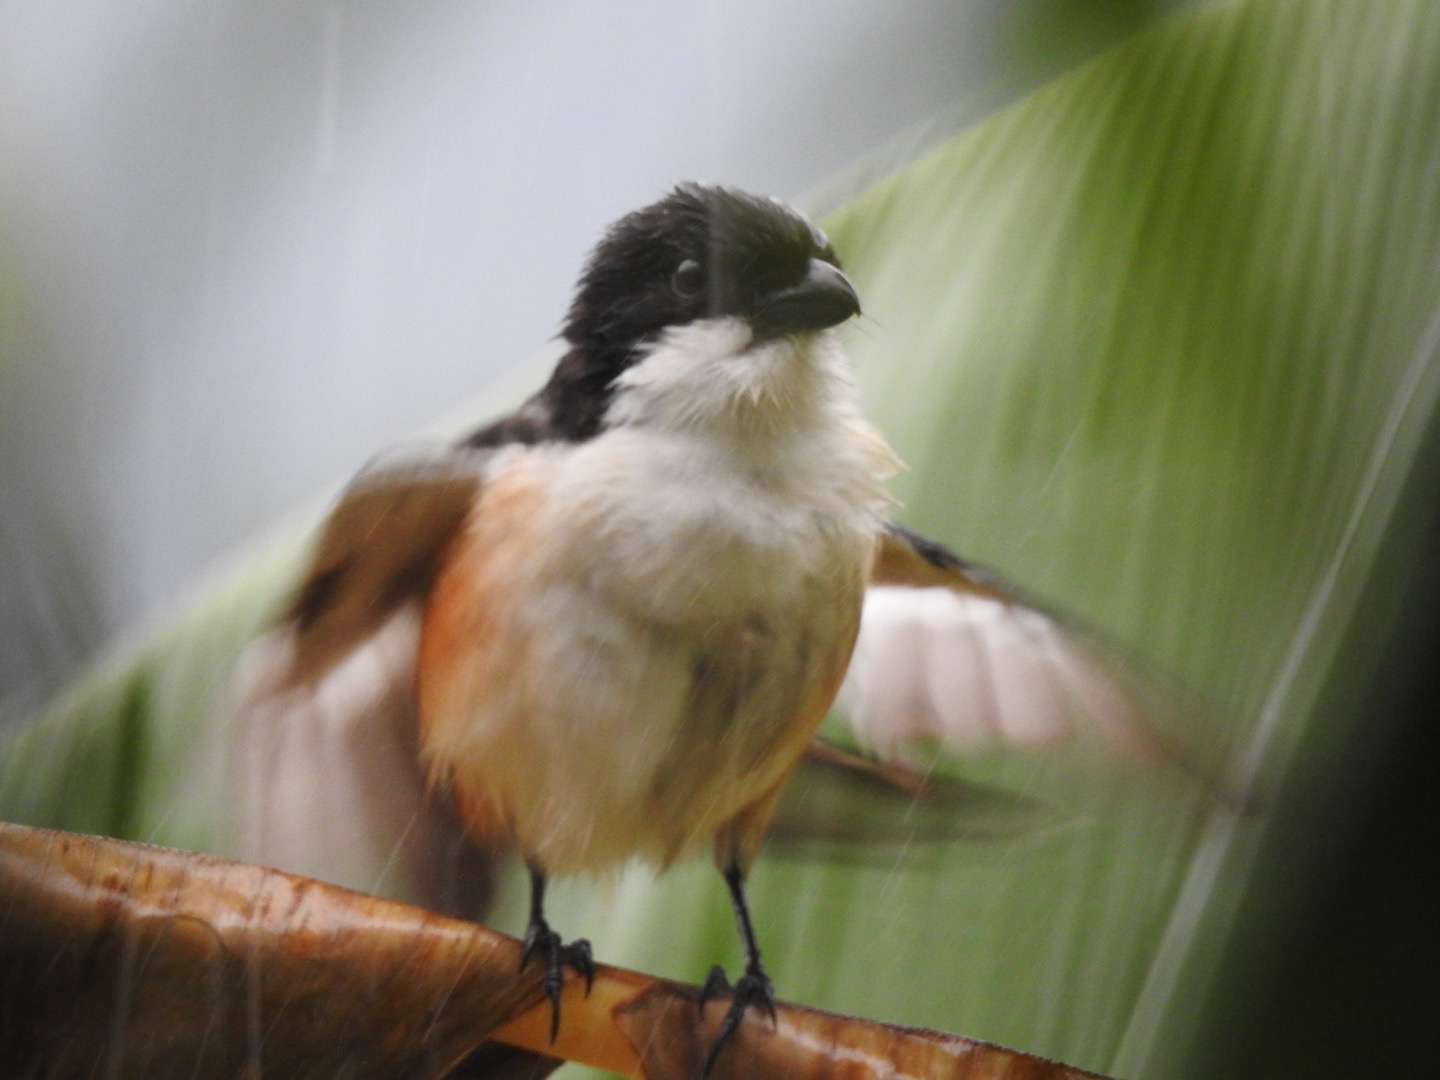

Type: torch.float32
Shape: torch.Size([3, 224, 224])


In [111]:
filename = input()

# Load a PIL Image given a file name from the current directory.
img = Image.open(filename)

# Display the loaded image on notebook.
display(img)

# Resize the image to 256x256. 
# Then crop the center square of the image. 
# Lastly, convert the image to a PyTorch Tensor.
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Convert the PIL image to tensor
img = transform(img)

# A simplified version is to simply transform the image to a tensor
#img = transforms.ToTensor()(img)

# Check img type and shape
print("Type:", img.dtype)
print("Shape:", img.shape)

### Output: Making a prediction

We will now use `img` tensor as input to the pre-trained `resnet18` model. 

Before running the model for prediction, there are 2 things that we should do:

1. Include a batch dimension. In this case, we are using a single image, so we need to add a batch size of 1. We use `rearrange` for this.
2. Execute inference withing `torch.no_grad()` context manager. This is because we do not want to track the gradients.

The expected output is a `torch.Tensor` of shape `(1, 1000)`. `resnet18` was pre-trained on ImageNet1k. We can use `torch.argmax` to get the index of the maximum value.

In [112]:
# We need the tensor to have a batch dimension of 1.
img = rearrange(img, 'c h w  -> 1 c h w')
print("New shape:", img.shape)

with torch.no_grad():
    pred = resnet(img)

print("Prediction shape:", pred.shape)
pred = torch.argmax(pred, dim=1)
print("Predicted index", pred)

New shape: torch.Size([1, 3, 224, 224])
Prediction shape: torch.Size([1, 1000])
Predicted index tensor([91])


#### Human: Convert class index to label

To make sense of the predicted index, we need to convert it to a label. We can use `https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a` to get the mapping from index to label. 


In [113]:
import urllib

filename = "imagenet1000_labels.txt"
url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"

# Download the file if it does not exist
if not os.path.isfile(filename):
    urllib.request.urlretrieve(url, filename)

with open(filename) as f:
    idx2label = eval(f.read())

print("Predicted label:", idx2label[pred.cpu().numpy()[0]])

Predicted label: coucal
